### Tuana – Lineer Modeller (Lojistik Regresyon & Ridge Classifier)



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


In [5]:
df = pd.read_csv("/Users/tuanasimsek/Desktop/VeriMadenciligiProjesi/data/merged_all_months.csv")

df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2970692 entries, 0 to 2970691
Data columns (total 13 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   date                          object 
 1   hour                          int64  
 2   route_code                    object 
 3   stop_code                     object 
 4   passenger_count               int64  
 5   vehicle_type                  int64  
 6   district                      object 
 7   is_outlier                    int64  
 8   is_peak_hour                  int64  
 9   day_of_week                   int64  
 10  is_weekend                    int64  
 11  mean_passenger_by_route_hour  float64
 12  month                         object 
dtypes: float64(1), int64(7), object(5)
memory usage: 294.6+ MB




Modelimizin hedef değişkeni olan yolcu yoğunluğu, yolcu sayısına göre 3 sınıfa ayrılmıştır:

- **0–9 → low**
- **10–49 → medium**
- **50+ → high**

Bu sınıflandırma ile sayısal yolcu sayısı kategorik bir hedef değişkene dönüştürülerek sınıflandırma modelleri için uygun hale getirilmiştir.



In [7]:
def classify_density(x):
    if x < 10:
        return 'low'
    elif x < 50:
        return 'medium'
    else:
        return 'high'

df['passenger_density'] = df['passenger_count'].apply(classify_density)

df['passenger_density'].value_counts()


passenger_density
low       2593964
medium     318994
high        57734
Name: count, dtype: int64

Yolcu Yoğunluğu Sınıflarının Dağılımı ,
Bu adımda oluşturulan passenger_density değişkeninin sınıf dağılımı incelenmiştir.

Grafik sayesinde sınıfların dengesiz olduğu görülmektedir:
- low sınıfı baskındır  
- medium orta düzeydedir  
- high sınıfı çok azdır  

Bu dengesizlik model performansını etkileyebilir.



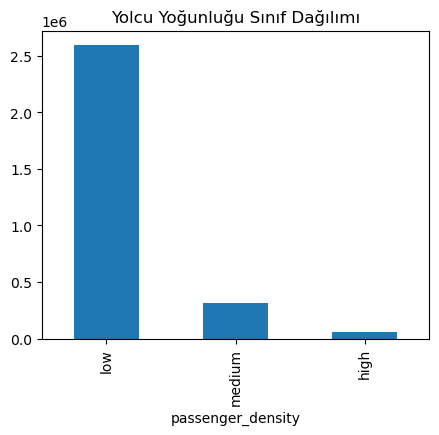

In [11]:
df['passenger_density'].value_counts().plot(kind="bar", figsize=(5,4))
plt.title("Yolcu Yoğunluğu Sınıf Dağılımı")
plt.show()


Saatlere Göre Yolcu Sayısının Görselleştirilmesi


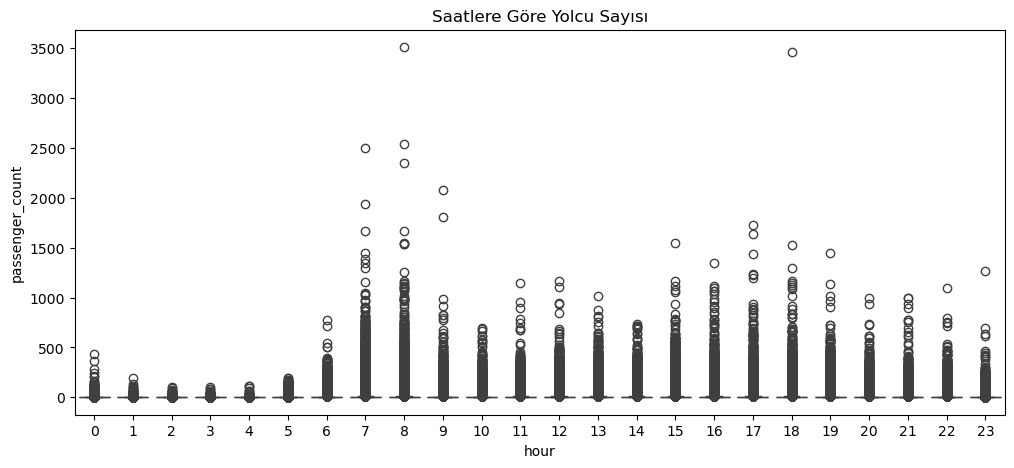

In [9]:
plt.figure(figsize=(12,5))
sns.boxplot(x="hour", y="passenger_count", data=df)
plt.title("Saatlere Göre Yolcu Sayısı")
plt.show()


Yoğunluk Sınıflarının Saatlere Göre Dağılımı


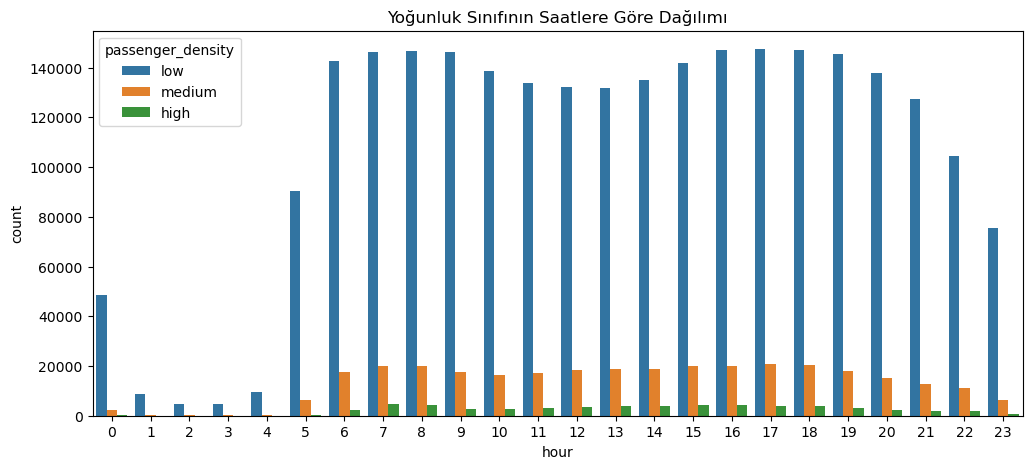

In [13]:
plt.figure(figsize=(12,5))
sns.countplot(x="hour", hue="passenger_density", data=df)
plt.title("Yoğunluk Sınıfının Saatlere Göre Dağılımı")
plt.show()


Hat Kodlarına Göre Ortalama Yolcu Sayısı


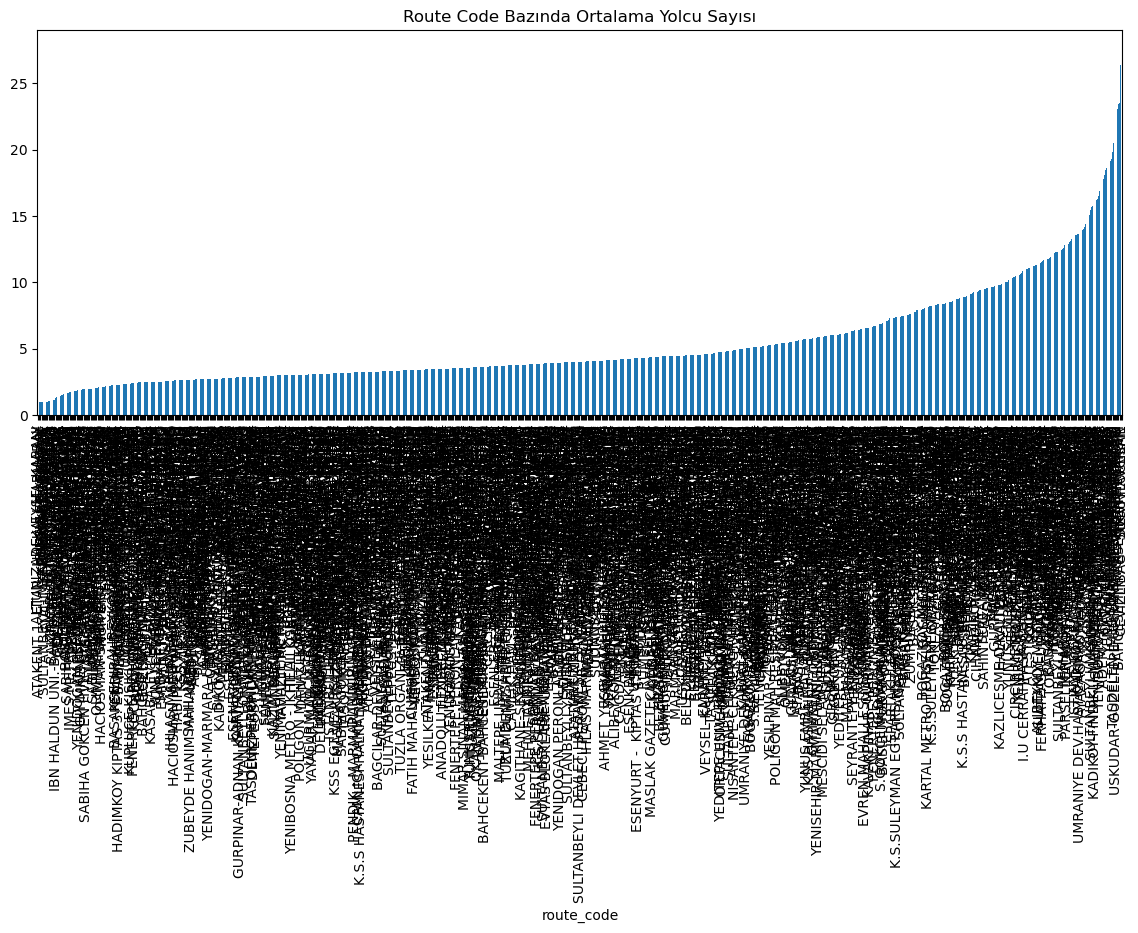

In [15]:
plt.figure(figsize=(14,5))
df.groupby("route_code")["passenger_count"].mean().sort_values().plot(kind="bar")
plt.title("Route Code Bazında Ortalama Yolcu Sayısı")
plt.show()


Özellik (X) ve Hedef (y) Ayrımının Yapılması
Modelde kullanılacak bağımsız değişkenler:

- hour 
- stop_code
- route_code

Hedef değişken:
- passenger_density

Bu adım, model eğitimine başlamadan önce veri yapısını belirler.


In [17]:
feature_cols = ['hour', 'stop_code', 'route_code']
target_col = 'passenger_density'

X = df[feature_cols].copy()
y = df[target_col].copy()

X.head()



,hour,stop_code,route_code
0,0,OTOYOL,MESCIDI SELAM-ARNAVUTKOY-ISTANBUL HAVA LIMANI
1,0,OTOYOL,MECIDIYEKOY-ISTANBUL HAVALIMANI
2,0,OTOYOL,KOC UNV. RUMELIFENER KAMPUSU - TAKSIM
3,0,OTOYOL,HACI OSMAN METRO - RUMELI FENERI
4,0,OTOYOL,USKUDAR-GUZELTEPE-UMRANIYE DEVLET HASTANESI


Kategorik Değişkenlerin Dönüştürülmesi

In [19]:
X_encoded = X.copy()
label_encoders = {}

cat_cols = ['stop_code', 'route_code']

for col in cat_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
    label_encoders[col] = le

X_encoded.head()


,hour,stop_code,route_code
0,0,1,586
1,0,1,580
2,0,1,535
3,0,1,344
4,0,1,803


Modelin Eğitim ve Test Setlerine Ayrılması

- stratify=y → Sınıf dengesizliğinde tüm sınıfların her iki sette eşit oranda bulunmasını sağlar.  


In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((2376553, 3), (594139, 3))

StandardScaler ile Ölçeklendirme
Hour ve encoded değişkenler farklı ölçeklerde olduğu için StandardScaler uygulanmıştır.

- Logistic Regression ve RidgeClassifier ölçekten ciddi şekilde etkilenir.  


In [25]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Logistic Regression Modeli
Bu model, yolcu yoğunluğunu tahmin etmek için kullanılan ilk lineer sınıflandırma yöntemidir.

Aşamalar:
- Modelin eğitilmesi  
- Test setinde tahmin yapılması  
- Accuracy, precision, recall, f1-score hesaplanması  
- Confusion matrix ile sınıf bazlı performansın görselleştirilmesi

Sonuçlar sınıf dengesizliği nedeniyle düşük macro skorlar üretmiştir.


Logistic Regression Accuracy: 0.8731845578223277


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report:
               precision    recall  f1-score   support

        high       0.00      0.00      0.00     11547
         low       0.87      1.00      0.93    518793
      medium       0.00      0.00      0.00     63799

    accuracy                           0.87    594139
   macro avg       0.29      0.33      0.31    594139
weighted avg       0.76      0.87      0.81    594139



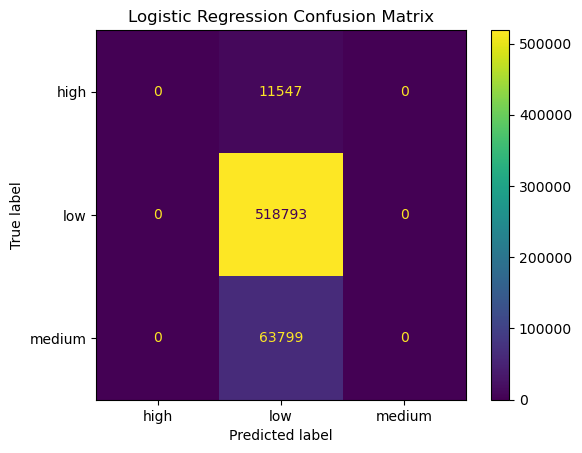

In [53]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)

y_pred_log = log_model.predict(X_test_scaled)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_log)
plt.title("Logistic Regression Confusion Matrix")
plt.show()


Ridge Classifier Modeli
Logistic Regression’a benzer fakat L2 regularization kullanan alternatiftir.

Aşamalar:
- Model eğitildi  
- Tahminler alındı  
- Metrikler hesaplandı  
- Confusion matrix çizildi  

RidgeClassifier’ın performansı Logistic Regression ile neredeyse aynıdır; sınıf dengesizliği yine büyük etki göstermektedir.


Ridge Classifier Accuracy: 0.8731845578223277


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report:
               precision    recall  f1-score   support

        high       0.00      0.00      0.00     11547
         low       0.87      1.00      0.93    518793
      medium       0.00      0.00      0.00     63799

    accuracy                           0.87    594139
   macro avg       0.29      0.33      0.31    594139
weighted avg       0.76      0.87      0.81    594139



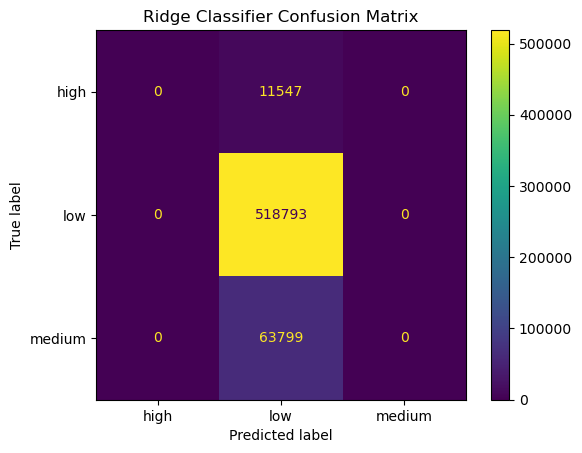

In [29]:
ridge_model = RidgeClassifier()
ridge_model.fit(X_train_scaled, y_train)

y_pred_ridge = ridge_model.predict(X_test_scaled)

print("Ridge Classifier Accuracy:", accuracy_score(y_test, y_pred_ridge))
print("\nClassification Report:\n", classification_report(y_test, y_pred_ridge))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_ridge)
plt.title("Ridge Classifier Confusion Matrix")
plt.show()


Modellerin Accuracy Karşılaştırması
Bu tabloda Logistic Regression ve Ridge Classifier modellerinin accuracy değerleri yan yana gösterilmiştir.

Amaç:
- Aynı feature subset ile eğitilen iki farklı lineer modelin performansını karşılaştırmak  
- Hangi modelin daha iyi genelleme yaptığını görmek  

Sonuç: Her iki model de benzer sonuçlar vermiştir.


In [31]:
results = pd.DataFrame({
    'model': ['Logistic Regression', 'Ridge Classifier'],
    'accuracy': [
        accuracy_score(y_test, y_pred_log),
        accuracy_score(y_test, y_pred_ridge)
    ]
})

results


,model,accuracy
0,Logistic Regression,0.873185
1,Ridge Classifier,0.873185
